# Transfer learning (domain adaptation)

Once the domain shift between phase 1 and phase 2 populations has been identified, let us jump to domain adaptation. Several techniques will be implemented:

1. Semi-supervised learning (use of the small subset of labelled data for learning)
2. Self-supervised learning (use model of phase 1 to label the data of phase 2)
3. Unsupervised domain adaptation (align phase 1 and phase 2 distributions in a common latent space)

(Some other approaches to face domain shift: 
- Domain Adversarial Training: Here, models are trained to have representations which cannot be easily distinguished between source and target using a domain discriminator.
- Subspace Alignment: Methods like CORrelation ALignment (CORAL) minimize domain shift by aligning the second-order statistics (covariance) of source and target features.
- Instance Re-weighting: Source instances are re-weighted based on their similarity to the target domain.
- Fine-tuning: After pre-training a model on the source domain, it is fine-tuned on a small labeled dataset from the target domain.)

In [262]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import prince

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *
from auxFuns.transfer_learning import *

In [261]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

import auxFuns.transfer_learning
importlib.reload(auxFuns.transfer_learning)

<module 'auxFuns.transfer_learning' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\transfer_learning.py'>

## Loading of data and dataframes preparation

In [4]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [5]:
# Only 2003 of the 3073 (~65%) patients who underwent a RSV test are present in the whole populations's dataset
patient_ids_rsv_test = labels_phase2_df.patient_id.unique()
patient_ids_phase2 = rsv_phase2_df.patient_id.unique()

len(patient_ids_rsv_test), len(patient_ids_phase2), (pd.Series(patient_ids_rsv_test).isin(patient_ids_phase2)).sum()

(3073, 40507, 2003)

In [6]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v2_aux = selected_features_v2.copy()
selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [7]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

df_modelling_phase1.shape, df_modelling_phase2.shape, df_modelling_all_phase2.shape

((86058, 21), (2867, 21), (291938, 20))

In [9]:
# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_modelling_phase2_labelled = df_modelling_phase2.copy()
df_modelling_phase2_nonlabelled = df_modelling_all_phase2.loc[non_labelled_mask,:]

df_modelling_phase1.shape, df_modelling_phase2_labelled.shape, df_modelling_phase2_nonlabelled.shape

((86058, 21), (2867, 21), (289071, 20))

In [ ]:
# Ensure consistency between source and target categories
df_modelling_phase2_labelled_copy = df_modelling_phase2_labelled.copy()
df_modelling_phase2_nonlabelled_copy = df_modelling_phase2_nonlabelled.copy()

df_modelling_phase2_labelled['n_tests_that_day'] = pd.Categorical(df_modelling_phase2_labelled_copy['n_tests_that_day'], categories=[1, 2])
df_modelling_phase2_nonlabelled['n_tests_that_day'] = pd.Categorical(df_modelling_phase2_nonlabelled_copy['n_tests_that_day'], categories=[1, 2])

## 1. Semi-supervised domain adaptation

Let us start by using the small subset of labelled data of phase 2. To this end, we will evaluate the following methods:

- Re weighting of key samples
- Alignment of the latent spaces
- Domain-adversarial training
 

In [140]:
df_modelling_phase2_labelled.RSV_test_result.value_counts(), 

positives_phase2 = df_modelling_phase2_labelled.RSV_test_result.value_counts()[1]
negatives_phase2 = df_modelling_phase2_labelled.RSV_test_result.value_counts()[0]
p_pos_phase2 = positives/(positives+negatives)
IR_phase2 = negatives/positives

print(f'Number of positive samples in labelled data phase 2: {positives_phase2}')
print(f'Proportion of positive labels: {p_pos_phase2}')
print(f'Imbalance ratio of phase 2 labelled data: {IR_phase2}')
# the imbalance in this case is even heavier than in phase 1 data

Number of positive samples in labelled data phase 2: 52
Proportion of positive labels: 0.018137425880711544
Imbalance ratio of phase 2 labelled data: 54.13461538461539


In [177]:
X_source = df_modelling_phase1.drop(['RSV_test_result'], axis = 1)
labels_source = df_modelling_phase1['RSV_test_result']

X_target = df_modelling_phase2_labelled.drop(['RSV_test_result'], axis = 1)
labels_target = df_modelling_phase2_labelled['RSV_test_result']

# Define the combined population too
X_combined = pd.concat([X_source, X_target], axis = 0)
y_combined = np.hstack((np.zeros(len(X_source)), np.ones(len(X_target))))

np.unique(y_combined, return_counts = True)

(array([0., 1.]), array([86058,  2867], dtype=int64))

In [274]:
# Visualize the small labelled set of phase 2
# Also, visualize how the labelled data is overlapped or not
random_seed = 42
n_components = 5

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_target)

df_labelled_phase2_visualization = famd.transform(X_target)

# Add the phase label for visualization
df_labelled_phase2_visualization['RSV_test_result'] = labels_source

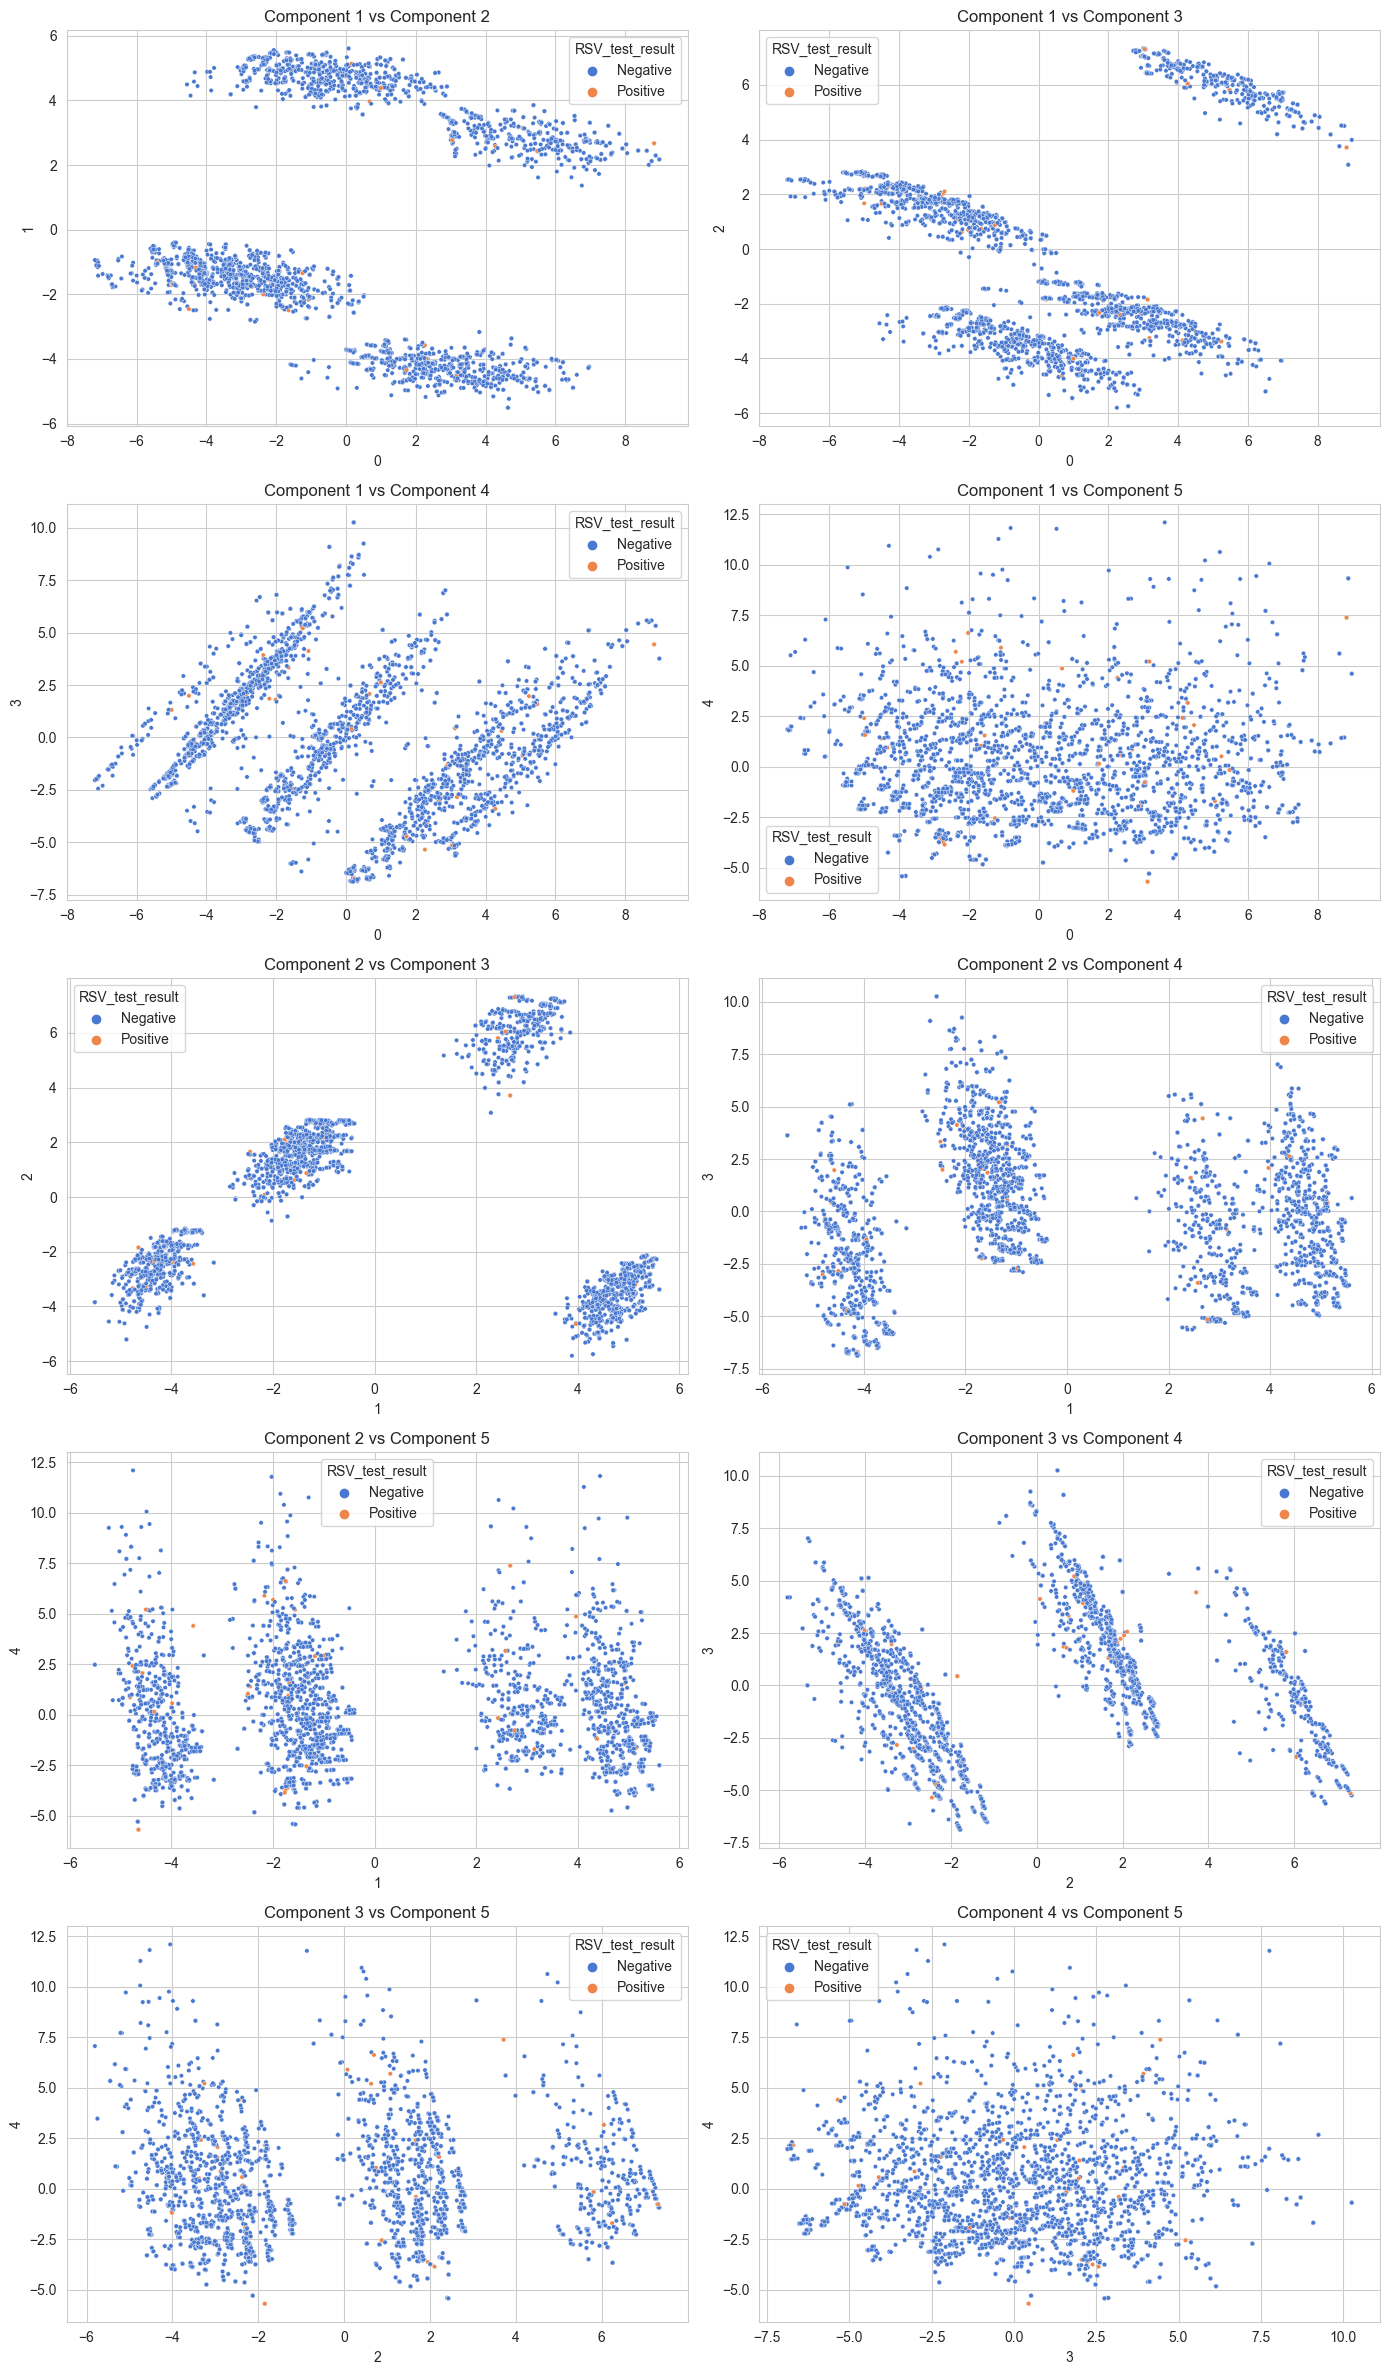

In [272]:
plot_5FMDA_planes(df = df_labelled_phase2_visualization, hue_target = 'RSV_test_result',s_size = 10)

In [147]:
# Also, visualize how the labelled data is overlapped or not
random_seed = 42
n_components = 5

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_combined)

df_labelled_data_visualization = famd.transform(X_combined)

# Add the phase label for visualization
df_labelled_data_visualization['labelled_phase'] = y_combined

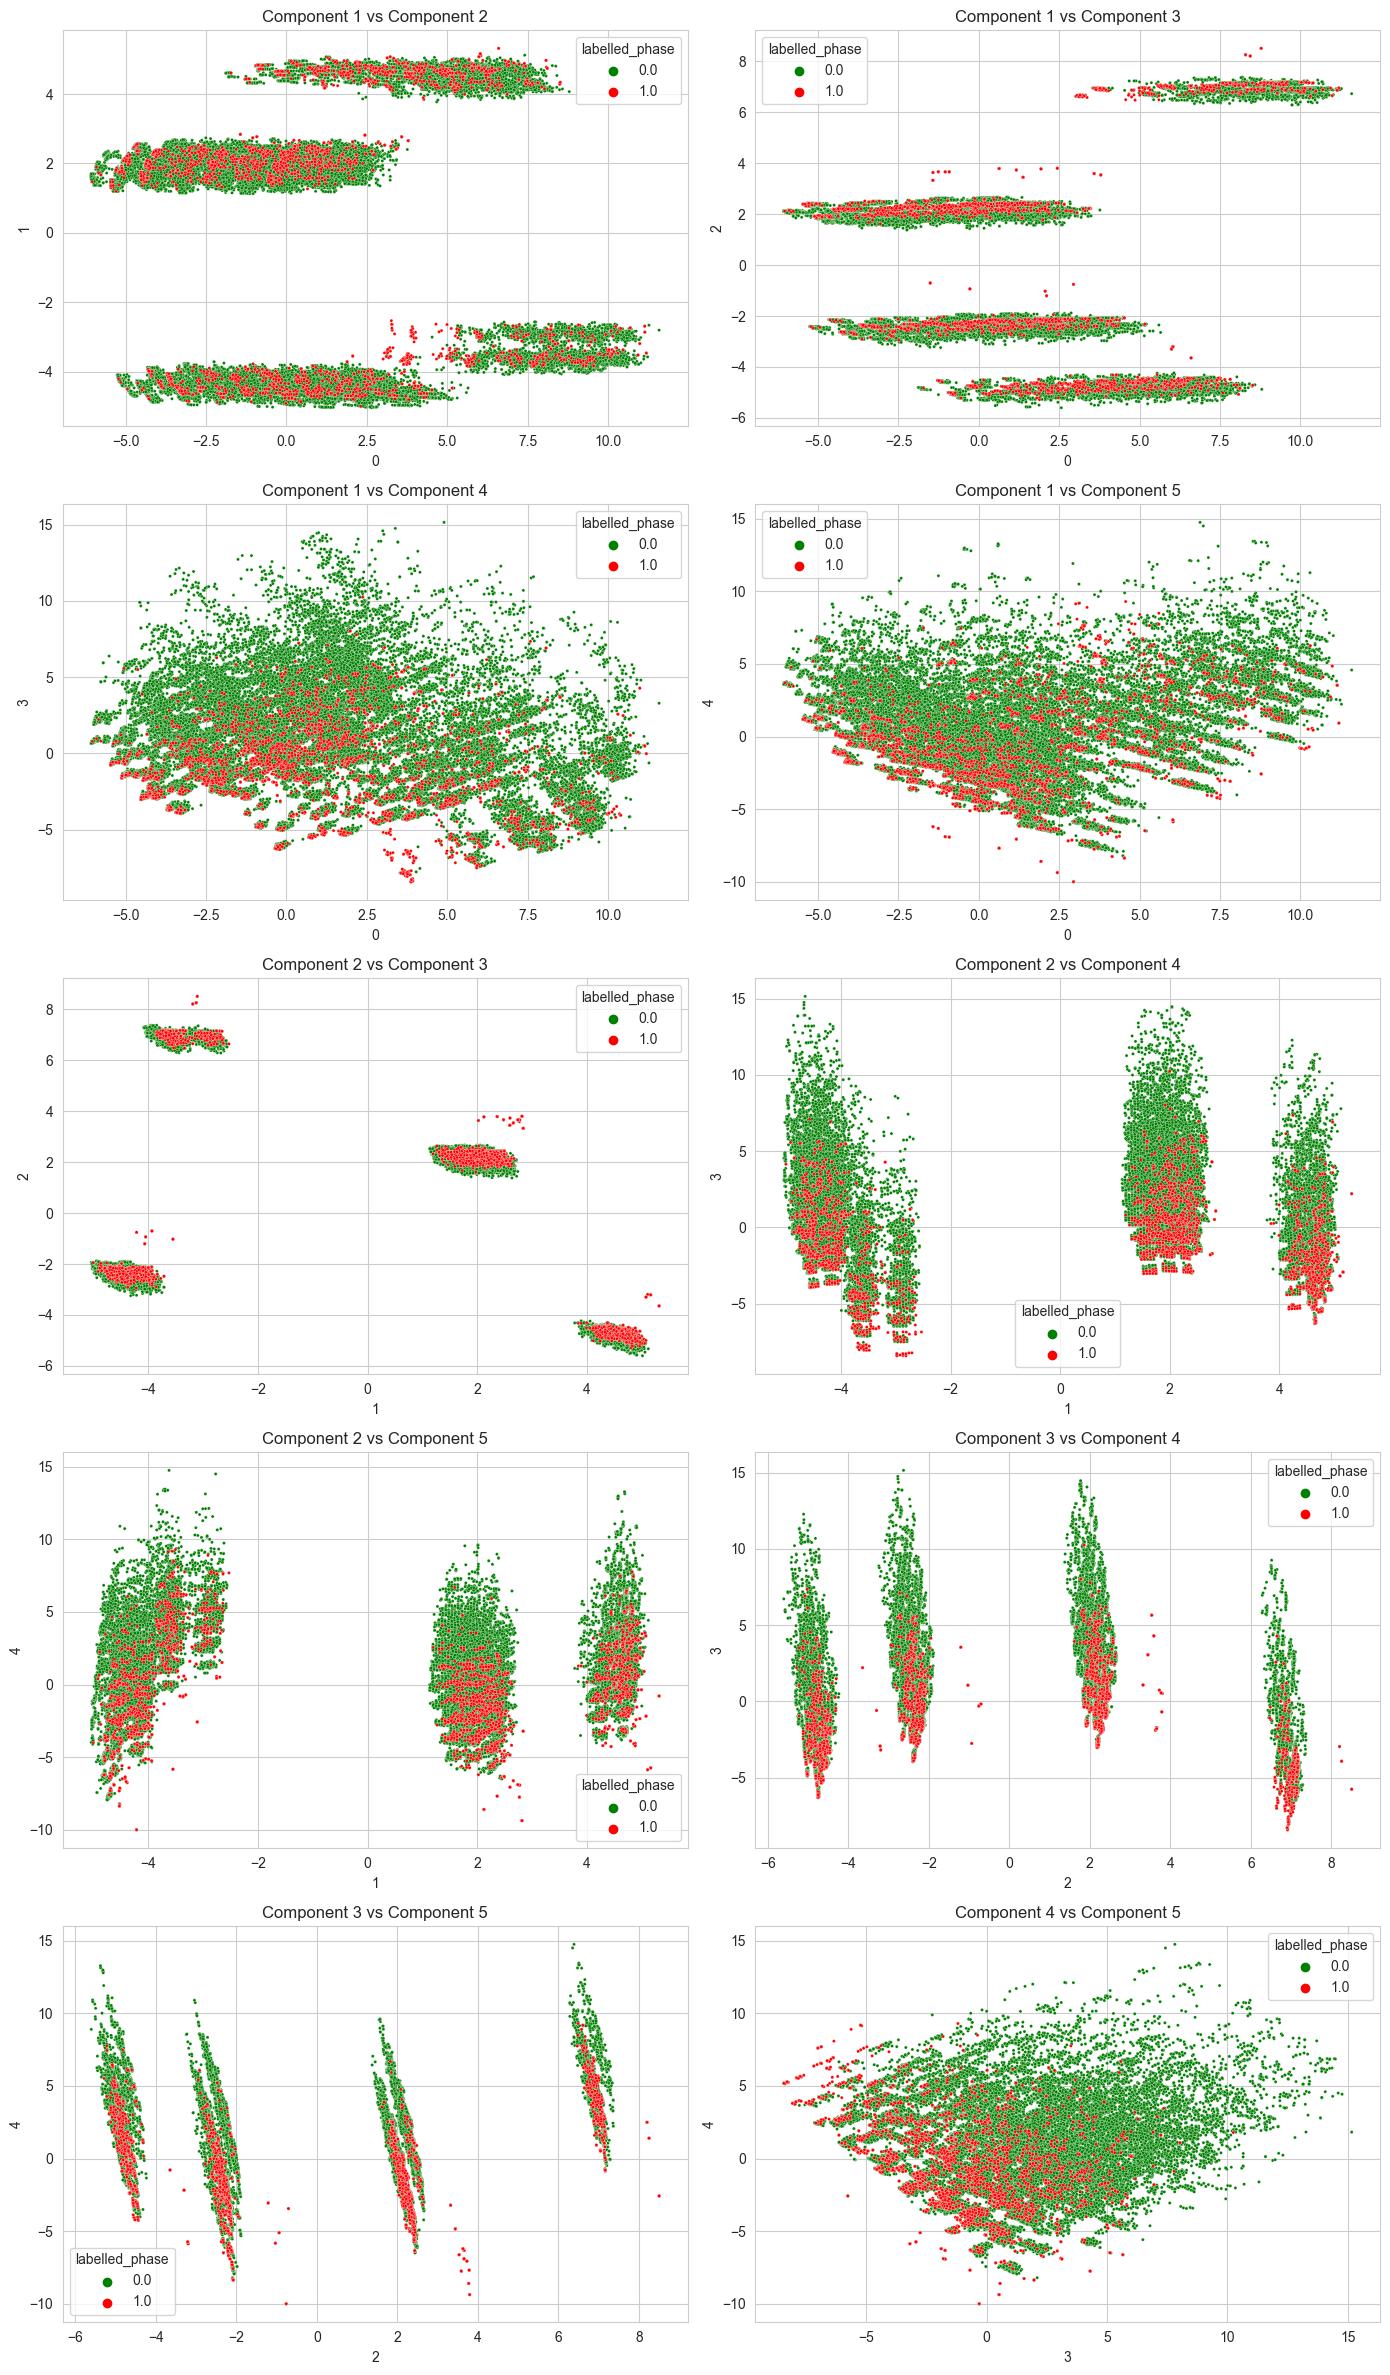

In [148]:
plot_5FMDA_planes(df = df_labelled_data_visualization, hue_target = 'labelled_phase', palette = {1: 'red', 0:'green'},s_size = 5)

These results are interesting as enable to differentiate between two clear areas of points in the source population:
- Some are clearly overlapped with phase 2 data
- Some are clearly separated

This will allow a more eficient weighting of the source instances

### Semi-supervised: instance-reweighting

Instance reweighting by itself can be challenging. We will follow the approach of using a discriminator to differentiate between phase 1 and phase 2 labelled data, and then use the prediction probabilities of that discriminator as weights.
1. Build a discriminator and compute the same-weights that will affect training of the model in phase 1 (output: source_instances_weights)
2. Train the model in phase 1 taking this source_instances_weights as sample weights in the model
3. Evaluate the retrained model in target data

In [186]:
# 1. Build the discriminator and compute the source_instance_weights
# i) build a classifier able to differentiate between phase 1 and phase 2 data
# ii) on the same set as the training, predict the probabilities to belonging to one or the other 
# iii) assign these probabilities as weights for the instance re-weighting process

# i: train a discriminator (and see its performance)
# all the followuing hyperparameters are introduced so the random forest is not too good at memorizing the training data
discriminator = RandomForestClassifier(n_estimators=15, 
                                       max_depth=10, 
                                       min_samples_split=10, 
                                       min_samples_leaf=5, 
                                       max_features=0.5, 
                                       oob_score=True,
                                       class_weight = {0:1, 1:15}).fit(pd.get_dummies(X_combined), y_combined)
print("OOB Score:", discriminator.oob_score_)

# discriminator = LogisticRegression().fit(pd.get_dummies(X_combined), y_combined)

# Predict for all instances (X_combined) to evaluate performance
probs_performance = discriminator.predict_proba(pd.get_dummies(X_combined))[:, 1] # Probabilities for class 1 (being part of target population)
y_pred_performance = probs_performance > 0.5
accuracy_discriminator = accuracy_score(y_combined, y_pred_performance)
recall_discriminator = recall_score(y_combined, y_pred_performance)
precision_discriminator = precision_score(y_combined, y_pred_performance)

print(f'Accuracy of the discriminator is: {accuracy_discriminator}')
print(f'Recall of the discriminator is: {recall_discriminator}')
print(f'Precision of the discriminator is: {precision_discriminator}')

# ii: predict the probabilities (for source data only, as we are interested in reweighting the instances of the source population)
probs_source = discriminator.predict_proba(pd.get_dummies(X_source))[:, 1] # Probabilities for class 1 (being part of target population)
probs_target = discriminator.predict_proba(pd.get_dummies(X_target))[:, 1]

# iii: define the weights for instance reweighting
source_instances_weights = probs_source / (1 - probs_source)
target_instances_weights = probs_target / (1.01 - probs_target)

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


OOB Score: 0.9679167838065785
Accuracy of the discriminator is: 0.9727073376440821
Recall of the discriminator is: 0.6616672479944192
Precision of the discriminator is: 0.5655933214072749


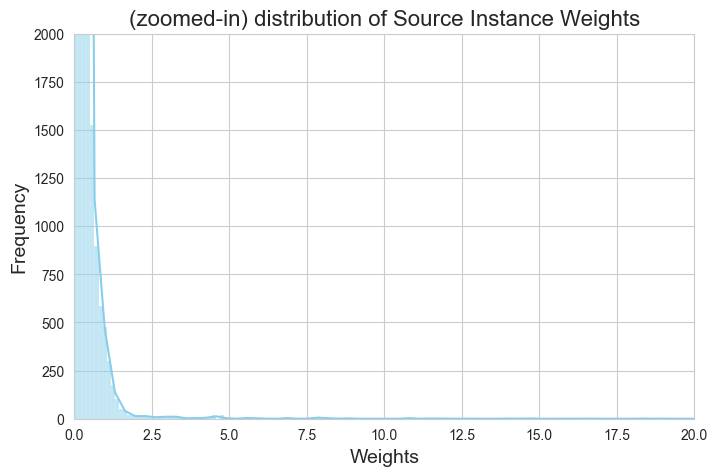

In [180]:
# Histogram for visualization of the final weights
weights = source_instances_weights[source_instances_weights >= 0]

sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(8,5))
sns.histplot(weights, bins=200, kde=True, color='skyblue')

plt.title('(zoomed-in) distribution of Source Instance Weights', fontsize=16)
plt.xlabel('Weights', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim([0,20]); plt.ylim([0,2000])
plt.show()

In [161]:
# 2. Re-train phase 1 model with the determined weights (source_instance_weights)
n_neighbours_to_determine_overlap = 4

# Determine the overlapping and non-overlapping onstances in source
X_source_dummies = pd.get_dummies(X_source)
y_source = labels_source.copy()
same_class_neighbours_dict_source, __, __, __ = calculate_same_neighbours_and_N1(X = X_source_dummies, y = y_source, n_neighbours = 5)


Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.0480606102860861
N1 metric for 2 neighbours : 0.07181203374468381
N1 metric for 3 neighbours : 0.09376234632457181
N1 metric for 4 neighbours : 0.11344674521834108
Done!


In [248]:
# Train the overlapping and non-overlapping models in phase 1 (source) data. Add the source_instance weights identified previously
print('\n------------------')
print('-------------------')
print('Fitting model on trainig data exclusively')
print(f'Building the two models using as reference {n_neighbours_to_determine_overlap} number of neighbours to determine overlap')
# Let us also add the source_instances_weights as feature for the model:

X_source_positivity = X_source.copy()
X_source_positivity['domain_likeliness_to_phase2'] = source_instances_weights

source_instances_weights_non_overlapping = source_instances_weights[same_class_neighbours_dict_source[n_neighbours_to_determine_overlap] == True]
source_instances_weights_overlapping = source_instances_weights[same_class_neighbours_dict_source[n_neighbours_to_determine_overlap] == False]


model_nonOverlapping, model_Overlapping = only_build_2overlapping_models(X = X_source_positivity, labels = y_source, same_class_neighbors = same_class_neighbours_dict_source[n_neighbours_to_determine_overlap], 
                                                                        random_seed = 42,
                                                                        model_class_non_overlapping = RandomForestClassifier(),
                                                                        param_grid_non_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_non_overlapping = False, weight_dict_non_overlapping = {'Negative': 1, 'Positive': 5},
                                                                        model_class_overlapping = RandomForestClassifier(),
                                                                        param_grid_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_overlapping = False, weight_dict_overlapping = {'Negative': 1, 'Positive': 5},
                                                                        sample_weights_Overlapping = source_instances_weights_overlapping, sample_weights_nonOverlapping = source_instances_weights_non_overlapping)


------------------
-------------------
Fitting model on trainig data exclusively
Building the two models using as reference 4 number of neighbours to determine overlap
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 200, 'Positive': 1},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.3906542056074766
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.09606657095810162


In [249]:
# 3. Evaluate the model in phase 2 labelled data
# 3.1. Take same_class_neighbours as hidden
X_target_positivity = X_target.copy()
X_target_positivity['domain_likeliness_to_phase2'] = target_instances_weights

X_target_dummies =  pd.get_dummies(X_target_positivity)
y_target = labels_target

preds_proba_nonOverlapping = model_nonOverlapping.predict_proba(X_target_dummies)[:,1]
preds_proba_Overlapping = model_Overlapping.predict_proba(X_target_dummies)[:,1]

soft_vote_weight_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5, 7, 10, 15, 20, 25, 30]
best_threshold_overlapping = None
best_performance_metric = float('-inf')

for soft_vote_weight in soft_vote_weight_values:
        
    y_probs = (1/(soft_vote_weight + 1)) * (preds_proba_nonOverlapping + soft_vote_weight*preds_proba_Overlapping)

    optimal_thr_aggregated = find_optimal_moving_threshold_from_probas(y_probs = y_probs, y_test = y_target, verbose = False)

    __, prec, recall, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs, y_test = y_target, threshold = optimal_thr_aggregated, print_roc = False, print_pr = False, verbose=False)

    if f1 > best_performance_metric:
        best_performance_metric = f1
        best_imbratio = soft_vote_weight
        best_recall = recall
        best_prec = prec

print("Best soft vote weight:", best_imbratio)
print("Best performance metric (f1) for RSV-positivity model:", best_performance_metric)     
print("Associated recall:", best_recall)        
print("Associated precision:", best_prec)  

Best soft vote weight: 0.7
Best performance metric (f1) for RSV-positivity model: 0.04187725631768953
Associated recall: 0.5576923076923077
Associated precision: 0.02175543885971493


In [252]:
# 3.2 Take same_class_neighbours as known for phase 2 labelled data

same_class_dict_target, __, __, __ = calculate_same_neighbours_and_N1(X = X_target_dummies, y = y_target, n_neighbours = 5)

true_overlapping_mask = ~same_class_dict_target[1]

y_probs_all = (true_overlapping_mask * preds_proba_Overlapping) + ((~true_overlapping_mask) * preds_proba_nonOverlapping)

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_all, y_test=y_target, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_all, y_test = y_target, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.032089291942797304
N1 metric for 2 neighbours : 0.044645971398674544
N1 metric for 3 neighbours : 0.062434600627834014
N1 metric for 4 neighbours : 0.07952563655388911
Done!
Optimal threshold: 0.86
Optimal f1: 0.02061855670103093


AUC Score: 0.27092498975269846
Precision / Positive predictive value: 0.014084507042253521
Specificity: 0.9502664298401421
Recall / sensitivity: 0.038461538461538464
Negative predictive value: 0.981651376146789
Accuracy: 0.9337286362050924
F-1: 0.02061855670103093
Precision-Recall AUC: 0.030266107288318078


Same problem as when non-source instances weighting is present: the model is **too biased towards positive samples**. The recall numbers are good but precision needs to be improved

### Semi-supervised: label shift mitigation

In this section we will implement the RLLS method [5], which specificly tackles domain shift. The steps to take are:

1. Dataset Split: Divide source dataset into training and validation sets. Training set to train the initial model and the validation set to **estimate the importance weights**.

2. Train an Initial Model: Train a classifier on the source training set. This classifier will serve as an initial model to which we will apply the RLLS corrections.

3. Estimate Source Label Distribution, in this case 3.0% positive and 97.0% negative.

4. Estimate Target Label Distribution: 1.8% positive and 98.2% negative.

5. Compute Importance Weights: Using the above distributions, compute the importance weights for each class, as indicated in the paper

6. Apply Importance Weights on Validation Set. 
​
7. Retrain or Adjust Classifier with Weight 

8. Evaluate on Target Data: Once the model has been adjusted for the label shift, evaluate its performance on the target dataset to determine how well it generalizes.

9. Regularization: sample-size-dependent regularization


[5] Azizzadenesheli, K., Liu, A., Yang, F., & Anandkumar, A. (2019). Regularized learning for domain adaptation under label shifts. arXiv preprint arXiv:1903.09734.


In [ ]:
# Short version of this: 

# Train the overlapping and non-overlapping models in phase 1 (source) data. Add the source_instance weights identified previously
print('\n------------------')
print('-------------------')
print('Fitting model on trainig data exclusively')
print(f'Building the two models using as reference {n_neighbours_to_determine_overlap} number of neighbours to determine overlap')
# Let us also add the source_instances_weights as feature for the model:

aux_same_class_neighbours = np.array([True]*X_source.shape[0])

model_nonOverlapping, model_Overlapping = only_build_2overlapping_models(X = X_source, labels = y_source, same_class_neighbors = aux_same_class_neighbours, 
                                                                        random_seed = 42,
                                                                        model_class_non_overlapping = RandomForestClassifier(),
                                                                        param_grid_non_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_non_overlapping = True, weight_dict_non_overlapping = {'Negative': 5, 'Positive': 1},
                                                                        )

In [264]:
# 3.2 Take same_class_neighbours as known for phase 2 labelled data
X_target_dummies =  pd.get_dummies(X_target)
y_target = labels_target

preds_proba_nonOverlapping = model_nonOverlapping.predict_proba(X_target_dummies)[:,1]
y_probs = preds_proba_nonOverlapping
optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs, y_test=y_target, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs, y_test = y_target, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)

Optimal threshold: 0.01
Optimal f1: 0.04


AUC Score: 0.5166586965432436
Precision / Positive predictive value: 0.020801232665639446
Specificity: 0.5484902309058615
Recall / sensitivity: 0.5192307692307693
Negative predictive value: 0.9840662842574889
Accuracy: 0.5479595395884199
F-1: 0.04
Precision-Recall AUC: 0.06528370943084441


In [ ]:
### Semi-supervised learning: fit a completely new model to phase 2 labelled data
same_class_dict_target, __, __, __ = calculate_same_neighbours_and_N1(X = X_target, y = y_target, n_neighbours = 5)

n_neighbours_to_model = 1

